# Convallaria Compression

In this tutorial we are going to learn how to compress the Convallaria model using EfficientBioAI toolkit. 

In [12]:
from functools import partial
from pathlib import Path
import yaml
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread, imsave
from scipy.ndimage import gaussian_filter

from deconoising import prediction
from unet.model import UNet
from deconoising import utils
from deconoising import training
from deconoising.utils import PSNR

device = torch.device("cpu")

## 1. Prepare the model and data

In [13]:
path = "./data/Convallaria_diaphragm/"
dataName = "convallaria"  # This will be used to name the network model
nameModel = dataName + "_network_example"  # specify the name of your network

# 1.1 model:
net = UNet(1, depth=3)
net = torch.load(path + "last_" + nameModel + ".net")

# 1.2 data for calibration:(same as training script)
fileName = "20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif"
data_image = imread(path + fileName)

meanValue = 520.0
data = np.array(data_image).astype(np.float32)
data = data - meanValue
data_list = [data[i] for i in range(data.shape[0])]
my_val_data = data_list[-5:]

# 2. Compress the model

In [14]:
def calibrate(
    model,
    dataloader,
    device=torch.device("cpu"),
):
    model.eval()
    model.to(device)
    for data in dataloader:
        prediction.tiledPredict(
            model, data, ps=512, overlap=48, device=device
        )  # we use the provided prediction function to predict the whole image


fine_tune = None

In [15]:
from efficientbioai.compress_ppl import Pipeline
from efficientbioai.utils.misc import Dict2ObjParser

In [16]:
cfg_path = Path("./custom_config.yaml")
with open(cfg_path, "r") as stream:
    config_yml = yaml.safe_load(stream)
    config = Dict2ObjParser(config_yml).parse()

In [ ]:
exp_path = Path("./exp")
Path.mkdir(exp_path, exist_ok=True)
pipeline = Pipeline.setup(config_yml)
pipeline(deepcopy(net), my_val_data, fine_tune, calibrate, exp_path)
pipeline.network2ir()

# 3. Run the compressed model

load data

In [18]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path = "./data/Convallaria_diaphragm/"
# Load the test data
dataTest = imread(path + "20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")
# We are loading only a sub image to spped up computation
dataTest = dataTest - 520.0  # subtract a mean value for the background
# We estimate the ground truth by averaging.
dataTestGT = np.mean(dataTest[:, ...], axis=0)[np.newaxis, ...]

In [19]:
from efficientbioai.infer.backend.openvino import create_opv_model

model_name = config.model.model_name
cfg_path = exp_path / f"{model_name}.yaml"
infer_path = exp_path / "academic_deploy_model.xml"

quantized_model = create_opv_model(infer_path)

In [20]:
def evaluate(model, dataTest, device):
    psnr_result = []
    psnr_input = []

    # We iterate over all test images.
    for index in range(dataTest.shape[0]):
        im = dataTest[index]
        gt = dataTestGT[0]  # The ground truth is the same for all images

        # We are using tiling to fit the image into memory
        # If you get an error try a smaller patch size (ps)
        # Here we are predicting the deconvolved and denoised image
        deconvolvedResult, denoisedResult = prediction.tiledPredict(
            model, im, ps=512, overlap=48, device=device
        )

        # calculate PSNR
        rangePSNR = np.max(gt) - np.min(gt)
        psnr_result.append(PSNR(gt, denoisedResult, rangePSNR))
        psnr_input.append(PSNR(gt, im, rangePSNR))
        print("image:", index)
        print("PSNR input", PSNR(gt, im, rangePSNR))
        print("PSNR denoised", PSNR(gt, denoisedResult, rangePSNR))
        print("-----------------------------------")

    # We display the results for the last test image
    vmi = np.percentile(gt, 0.01)
    vma = np.percentile(gt, 99)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(im, vmax=vma, vmin=vmi, cmap="magma")

    plt.subplot(1, 3, 2)
    plt.title("Deconv. output")
    plt.imshow(deconvolvedResult, vmax=vma, vmin=vmi, cmap="magma")

    plt.subplot(1, 3, 3)
    plt.title("Denoised output")
    plt.imshow(denoisedResult, vmax=vma, vmin=vmi, cmap="magma")

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(im[100:200, 150:250], vmax=vma, vmin=vmi, cmap="magma")

    plt.subplot(1, 3, 2)
    plt.title("Deconv. output")
    plt.imshow(deconvolvedResult[100:200, 150:250], vmax=vma, vmin=vmi, cmap="magma")

    plt.subplot(1, 3, 3)
    plt.title("Denoised output")
    plt.imshow(denoisedResult[100:200, 150:250], vmax=vma, vmin=vmi, cmap="magma")
    print(
        "Avg PSNR input:",
        np.mean(np.array(psnr_input)),
        "+-(2SEM)",
        2 * np.std(np.array(psnr_input)) / np.sqrt(float(len(psnr_input))),
    )
    print(
        "Avg PSNR denoised:",
        np.mean(np.array(psnr_result)),
        "+-(2SEM)",
        2 * np.std(np.array(psnr_result)) / np.sqrt(float(len(psnr_result))),
    )

for the compressed model:

0 512 0 512
(512, 512)
464 976 0 512
(512, 512)
512 1440 0 512
(512, 512)
0 512 464 976
(512, 512)
464 976 464 976
(512, 512)
512 1440 464 976
(512, 512)
0 512 512 1440
(512, 512)
464 976 512 1440
(512, 512)
512 1440 512 1440
(512, 512)
image: 0
PSNR input 32.04019187124313
PSNR denoised 38.224664367445556
-----------------------------------
0 512 0 512
(512, 512)
464 976 0 512
(512, 512)
512 1440 0 512
(512, 512)
0 512 464 976
(512, 512)
464 976 464 976
(512, 512)
512 1440 464 976
(512, 512)
0 512 512 1440
(512, 512)
464 976 512 1440
(512, 512)
512 1440 512 1440
(512, 512)
image: 1
PSNR input 32.067836383352216
PSNR denoised 38.22340003170663
-----------------------------------
0 512 0 512
(512, 512)
464 976 0 512
(512, 512)
512 1440 0 512
(512, 512)
0 512 464 976
(512, 512)
464 976 464 976
(512, 512)
512 1440 464 976
(512, 512)
0 512 512 1440
(512, 512)
464 976 512 1440
(512, 512)
512 1440 512 1440
(512, 512)
image: 2
PSNR input 32.04507212497453
PSNR denoised 38.22306062309807
-----

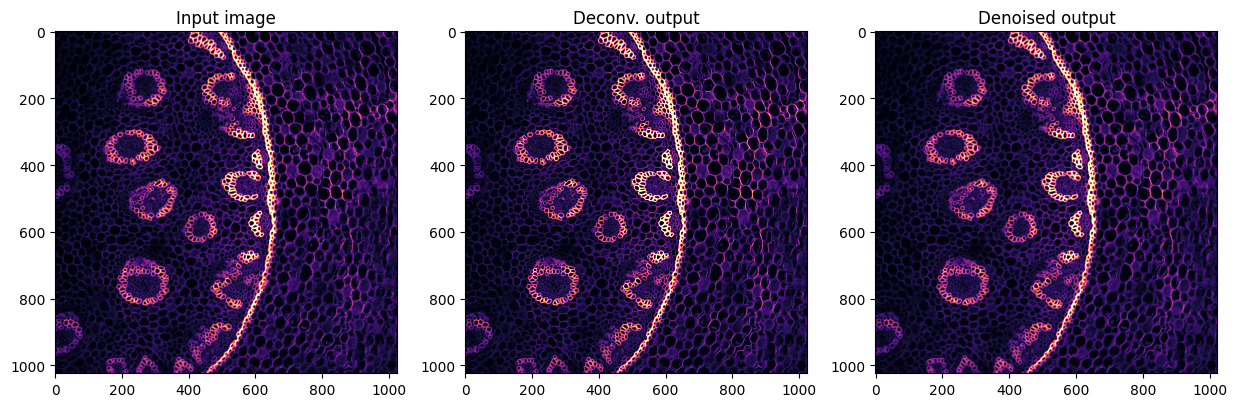

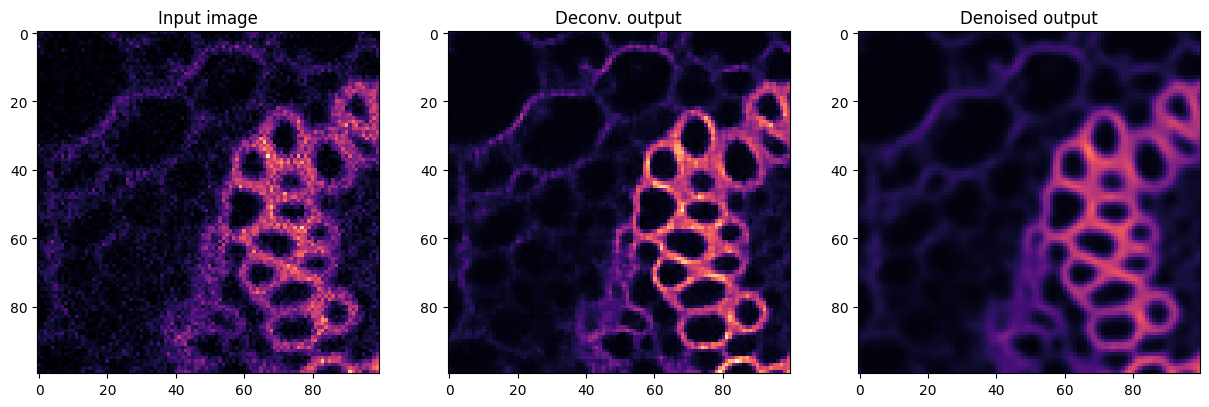

In [21]:
evaluate(quantized_model, dataTest, device)

for the normal model:

0 512 0 512
(512, 512)
464 976 0 512
(512, 512)
512 1440 0 512
(512, 512)
0 512 464 976
(512, 512)
464 976 464 976
(512, 512)
512 1440 464 976
(512, 512)
0 512 512 1440
(512, 512)
464 976 512 1440
(512, 512)
512 1440 512 1440
(512, 512)
image: 0
PSNR input 32.04019187124313
PSNR denoised 38.29474969680038
-----------------------------------
0 512 0 512
(512, 512)
464 976 0 512
(512, 512)
512 1440 0 512
(512, 512)
0 512 464 976
(512, 512)
464 976 464 976
(512, 512)
512 1440 464 976
(512, 512)
0 512 512 1440
(512, 512)
464 976 512 1440
(512, 512)
512 1440 512 1440
(512, 512)
image: 1
PSNR input 32.067836383352216
PSNR denoised 38.28587532549876
-----------------------------------
0 512 0 512
(512, 512)
464 976 0 512
(512, 512)
512 1440 0 512
(512, 512)
0 512 464 976
(512, 512)
464 976 464 976
(512, 512)
512 1440 464 976
(512, 512)
0 512 512 1440
(512, 512)
464 976 512 1440
(512, 512)
512 1440 512 1440
(512, 512)
image: 2
PSNR input 32.04507212497453
PSNR denoised 38.28334825729713
------

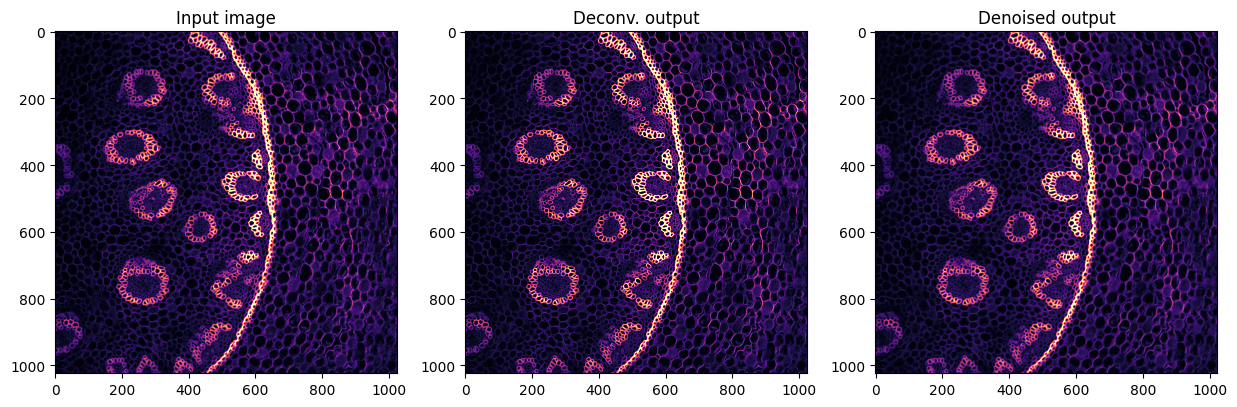

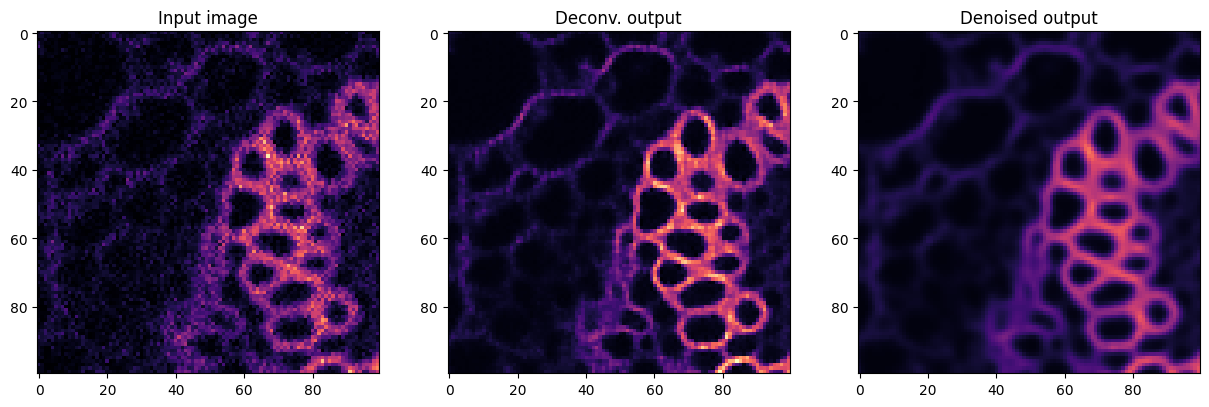

In [23]:
evaluate(net.cpu(), dataTest, device)

The speed comparison between the original model and the compressed model: